In [4]:
from ladybug.epw import EPW

epw = EPW('data/Weather/USA_CA_San.Jose-Mineta.epw')



In [11]:
import pandas as pd

# Path to your EPW file
file_path = 'data/Weather/USA_CA_San.Jose-Mineta.epw'  # Replace with your actual path

# Load the EPW data, skipping the 8-line header
df = pd.read_csv(file_path, skiprows=8, header=None)

# Assign column names based on the EPW format
df.columns = [
    "Year", "Month", "Day", "Hour", "Minute",
    "Data Source and Uncertainty Flags", "Dry Bulb Temperature [°C]",
    "Dew Point Temperature [°C]", "Relative Humidity [%]",
    "Atmospheric Station Pressure [Pa]", "Extraterrestrial Horizontal Radiation [Wh/m2]",
    "Extraterrestrial Direct Normal Radiation [Wh/m2]",
    "Horizontal Infrared Radiation Intensity from Sky [Wh/m2]",
    "Global Horizontal Radiation [Wh/m2]", "Direct Normal Radiation [Wh/m2]",
    "Diffuse Horizontal Radiation [Wh/m2]", "Global Horizontal Illuminance [lux]",
    "Direct Normal Illuminance [lux]", "Diffuse Horizontal Illuminance [lux]",
    "Zenith Luminance [cd/m2]", "Wind Direction [°]", "Wind Speed [m/s]",
    "Total Sky Cover [tenths]", "Opaque Sky Cover [tenths]", "Visibility [km]",
    "Ceiling Height [m]", "Present Weather Observation", "Present Weather Codes",
    "Precipitable Water [mm]", "Aerosol Optical Depth [thousandths]",
    "Snow Depth [cm]", "Days Since Last Snowfall", "Albedo",
    "Liquid Precipitation Depth [mm]", "Liquid Precipitation Quantity [hr]"
]

# Optionally: create a datetime column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) - pd.to_timedelta(1, unit='h')

# Set datetime as index (optional)
df.set_index('Datetime', inplace=True)
df.drop(columns=["Data Source and Uncertainty Flags"], inplace=True)

# Preview
df.columns


Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Dry Bulb Temperature [°C]',
       'Dew Point Temperature [°C]', 'Relative Humidity [%]',
       'Atmospheric Station Pressure [Pa]',
       'Extraterrestrial Horizontal Radiation [Wh/m2]',
       'Extraterrestrial Direct Normal Radiation [Wh/m2]',
       'Horizontal Infrared Radiation Intensity from Sky [Wh/m2]',
       'Global Horizontal Radiation [Wh/m2]',
       'Direct Normal Radiation [Wh/m2]',
       'Diffuse Horizontal Radiation [Wh/m2]',
       'Global Horizontal Illuminance [lux]',
       'Direct Normal Illuminance [lux]',
       'Diffuse Horizontal Illuminance [lux]', 'Zenith Luminance [cd/m2]',
       'Wind Direction [°]', 'Wind Speed [m/s]', 'Total Sky Cover [tenths]',
       'Opaque Sky Cover [tenths]', 'Visibility [km]', 'Ceiling Height [m]',
       'Present Weather Observation', 'Present Weather Codes',
       'Precipitable Water [mm]', 'Aerosol Optical Depth [thousandths]',
       'Snow Depth [cm]', 'Days Since Last Sno

In [15]:
import pandas as pd

def time_series_data_center_model_with_temp(it_load_kw, outside_temps_c, timestep_hr=1, thermal_mass_kwh_per_c=500):
    results = []
    internal_temp = 25  # Initial internal air temp in °C
    target_temp = 25

    for temp_c in outside_temps_c:
        # Chiller COP model
        chiller_cop = max(3, min(6, 7 - 0.1 * temp_c))

        # CRAH fan power
        crah_shr = 0.97
        fan_efficiency = 0.8
        fan_power_kw = (it_load_kw * (1 - crah_shr)) / fan_efficiency

        # Pump power
        pump_efficiency = 0.7
        cooling_load_kw = it_load_kw + fan_power_kw
        pump_power_kw = cooling_load_kw * 0.05 / pump_efficiency

        # Determine how much heat is removed this timestep (kWh)
        if internal_temp > target_temp:
            # Assume cooling matches load
            chiller_power_kw = cooling_load_kw / chiller_cop
            heat_removed_kwh = cooling_load_kw * timestep_hr
        else:
            # Chillers don't run
            chiller_power_kw = 0
            heat_removed_kwh = 0

        # Net heat added = IT + fans – removed
        net_heat_added_kwh = (it_load_kw + fan_power_kw) * timestep_hr - heat_removed_kwh

        # Update internal temp
        delta_temp = net_heat_added_kwh / thermal_mass_kwh_per_c
        internal_temp += delta_temp

        # UPS and total facility power
        ups_efficiency = 0.95
        power_from_grid_kw = it_load_kw / ups_efficiency
        total_facility_kw = power_from_grid_kw + fan_power_kw + pump_power_kw + chiller_power_kw
        pue = total_facility_kw / it_load_kw

        results.append({
            "Outside Temp (°C)": temp_c,
            "Internal Temp (°C)": round(internal_temp, 2),
            "Chiller COP": round(chiller_cop, 2),
            "Fan Power (kW)": round(fan_power_kw, 2),
            "Pump Power (kW)": round(pump_power_kw, 2),
            "Chiller Power (kW)": round(chiller_power_kw, 2),
            "Total Facility Power (kW)": round(total_facility_kw, 2),
            "PUE": round(pue, 3)
        })

    return pd.DataFrame(results)


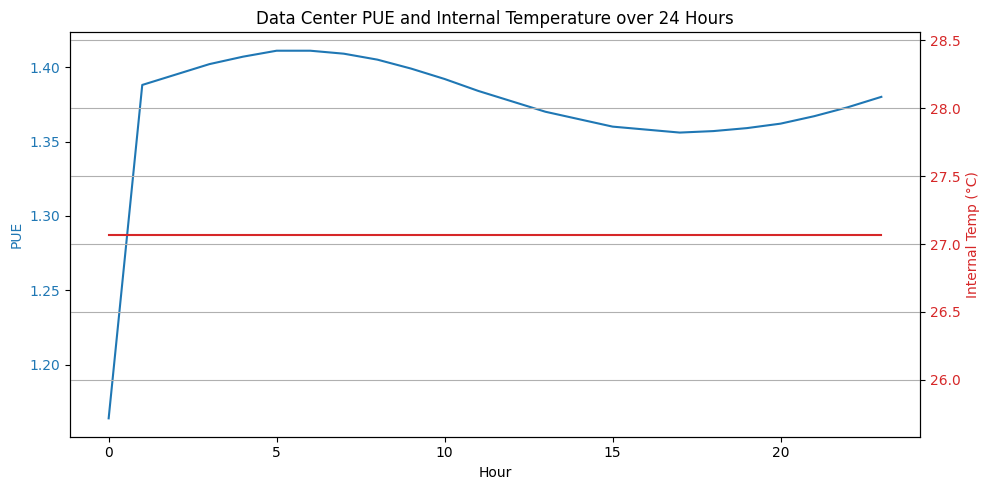

In [16]:
import numpy as np
import matplotlib.pyplot as plt

temps = 22 + 6 * np.sin(np.linspace(0, 2 * np.pi, 24))  # hourly temps
df = time_series_data_center_model_with_temp(it_load_kw=1000, outside_temps_c=temps)

# Plot PUE and Internal Temp
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Hour")
ax1.set_ylabel("PUE", color="tab:blue")
ax1.plot(df["PUE"], color="tab:blue", label="PUE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Internal Temp (°C)", color="tab:red")
ax2.plot(df["Internal Temp (°C)"], color="tab:red", label="Internal Temp")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Data Center PUE and Internal Temperature over 24 Hours")
fig.tight_layout()
plt.grid(True)
plt.show()
